In [2]:
"""
타이타닉 생존자 예측 프로잭트(오하림)

1. 데이터셋 불러오기
2. feature 분석
3. feature engineering
"""

'\n타이타닉 생존자 예측 프로잭트(오하림)\n\n1. 데이터셋 불러오기\n2. feature 분석\n3. feature engineering\n'

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
    

===1. 데이터셋 불러오기 ====

1.1 데이터셋 불러오기
     survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female   NaN      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adu

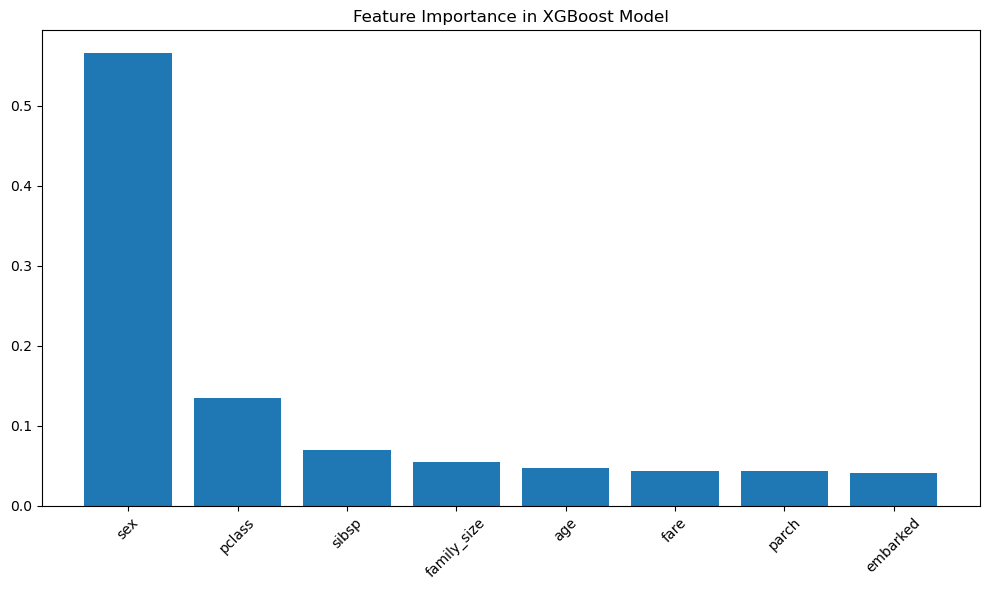

In [79]:
def load_and_analyze_data():
    """
    1. 데이터셋 불러오기
    """
    print('===1. 데이터셋 불러오기 ====')
    # 데이터셋 불러오기
    print('\n1.1 데이터셋 불러오기')
    titanic = sns.load_dataset('titanic')
    print(titanic)

    """
    2. feature 분석
    """
    print("\n===2. feature 분석 ===")
    
    # 2.1 데이터 기본 정보
    print("\n2.1 데이터 기본 정보")
    print(titanic.head())
  
    # 2.2 데이터 통계
    print("\n2.2 데이터 통계")
    print(titanic.describe())
    
    # 2.3 데이터 통계 분석
    print("\n2.3 데이터 통계 분석")
    print("count는 데이터의 총 개수입니다. 결측값없이 데이터가 존재함을 보여줍니다.")
    print("mean는 평균값입니다. 데이터의 중심경향을 보여줍니다.")
    print("std는 표준편차입니다. 데이터 값들의 흩어짐 정도를 보여줍니다.")
    print("min는 최솟값입니다. 데이터 중 가장 작은 값을 보여줍니다.")
    print("25%는 1사분위수입니다. 데이터의 하위 25%에 해당하는 값을 보여줍니다.")
    print("50%는 중위수입니다. 데이터 중앙에 해당하는 값을 보여줍니다.")
    print("75%는 3분위수입니다. 데이터 상위25%를 제외한 값을 보여줍니다.")    
    print("max는 최대값입니다. 데이터중 가장 큰 값을 보여줍니다.")

     # 2.4 결측치 개수 확인
    print("\n2.4 결측치 개수")
    print(titanic.isnull().sum())

    """
    3. feature engineering
    """
    print("\n===3. feature engineering ===")
    
    # 3.1 결측치 처리
    print("\n3.1 결측치 처리")
    
    # 나이 결측치를 중앙값으로 채우기
    titanic['age'] = titanic['age'].fillna(titanic['age'].median())
    
    # 승선 항구 결측치를 최빈값으로 채우기
    titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
    print(titanic['age'].isnull().sum())
    print(titanic['embarked'].isnull().sum())
    
    # 3.2 수치형으로 인코딩
    print("\n3.2 수치형으로 인코딩")
    titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
    titanic['alive'] = titanic['alive'].map({'no': 1, 'yes': 0})
    titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2,})

    print(titanic['sex'].head())
    print(titanic['alive'].head())
    print(titanic['embarked'].head())

    # 3.3 새로운 feature 생성
    print("\n3.3 새로운 feature 생성")
    titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1
    print(titanic['family_size'].head())

    """

    4. 모델 학습시키기(XGBoost) 
    """
    
    print("\n===4. 모델 학습시키기(XGBoost) ===")
    # 4.1 모델 학습 준비
    print("\n4.1 모델 학습 준비")
    titanic = titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size']]
    X = titanic.drop('survived', axis=1) # feature
    y = titanic['survived'] # target

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # 데이터 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4.2 GridSearchCV를 사용한 하이퍼파라미터 튜닝
    print("\n4.2 GridSearchCV를 사용한 하이퍼파라미터 튜닝")
    
    # 탐색할 하이퍼파라미터 범위 설정
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.3],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    }

    # XGBoost 모델 생성
    xgb_model = xgb.XGBRegressor(random_state=42)

    # GridSearchCV 객체 생성
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        scoring='neg_mean_squared_error',
        verbose=2
    )

    # 그리드 서치 수행
    grid_search.fit(X_train_scaled, y_train)

    # 최적의 파라미터와 성능 출력
    print("\n최적의 하이퍼파라미터:")
    print(grid_search.best_params_)
    print("\n최적의 CV 점수:")
    print(f"MSE: {-grid_search.best_score_:.4f}")

    # 최적의 모델로 테스트 세트 예측
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f"\n테스트 세트 MSE: {mse:.4f}")

    # Feature importance 시각화
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance in XGBoost Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return titanic, best_model, grid_search

if __name__ == "__main__":
    titanic, best_model, grid_search = load_and_analyze_data()